In [1]:
%matplotlib inline
# All required dependencies for all plots 
import aplpy
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from NOEMAsetup import *
from spectral_cube import SpectralCube
from ChauvenetRMS import *
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import AsinhStretch
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Ellipse, Rectangle
import copy
import pickle
import velocity_tools.stream_lines as SL
from scipy import stats

In [2]:
def plot_aplpy_standard(image, stretch, vmin, vmax, cmap, phasecent=[ra_Per50, dec_Per50], vmid=0.01, figsize=(4,4), label_col='w', star_col='r'):
    fig = aplpy.FITSFigure(image, figsize=figsize)
    if stretch=='arcsinh':
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax, vmid=vmid)
    else:
        fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.add_colorbar()
    setup_plot_noema(fig, label_col=label_col, star_col=star_col)
    fig.beam.set_color('k')
    fig.beam.set_frame(True)
    fig.scalebar.set_linewidth(2)
    return fig

## SO(55-44) plots

### Moment 0

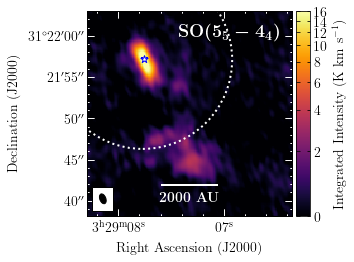

In [37]:
saveaction = 0
folder = 'SO_55_44/CDconfigsmall/'
filename = folder + 'Per-emb-50_CD_l009l048_uvsub_SO_multi_small_fitcube_stream_mom0'
stretch = 'arcsinh'

savefile = filename + '_'+stretch + '.pdf'
vmin = 0
vmax = 16
vmid = 2
cmap = 'inferno'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]
title = r'\textbf{SO(\boldmath$5_{5}-4_{4}$)}'

fig = plot_aplpy_standard(filename + '.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.95,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
if saveaction:
  plt.savefig(savefile, dpi=300, bbox_inches='tight')

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


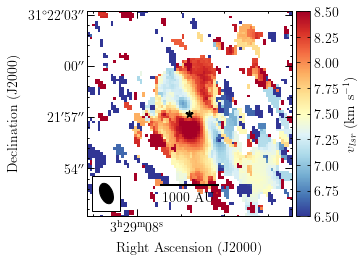

In [18]:
saveaction = 1
folder = 'SO_55_44/CDconfig/'
filename = folder + 'Per-emb-50_CD_l009l048_uvsub_SO_multi_velocity_python'
stretch = 'linear'

savefile = filename + '_'+stretch + '.pdf'
vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'

fig = plot_aplpy_standard(filename + '.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='k')
fig.recenter(ra_Per50.value, dec_Per50.value, (6*u.arcsec).to(u.deg).value)
fig.scalebar.set_length(1000/293/3600)
fig.scalebar.set_label('1000 AU')
fig.colorbar.set_axis_label_text(r'$v_{lsr}$ (km s$^{-1}$)')
if saveaction:
  plt.savefig(savefile, dpi=300, bbox_inches='tight')

### SO(55-44) 1- and 2-Gaussian fit

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorma

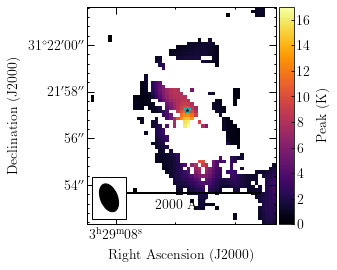

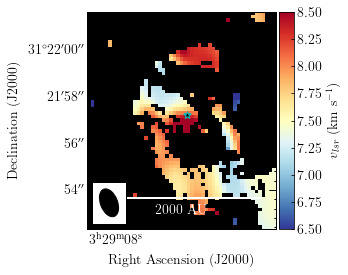

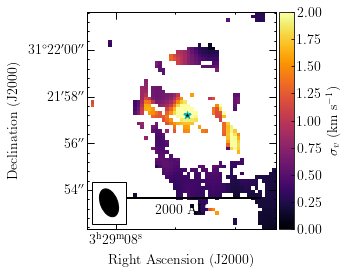

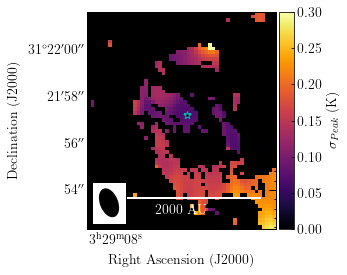

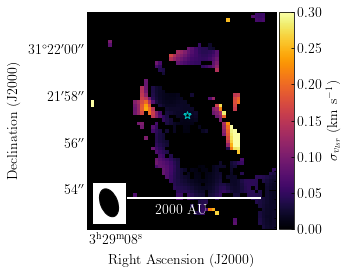

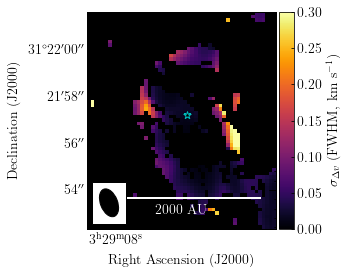

In [77]:
# Load the cube with pyspeckit
saveaction = 1

filename = 'SO_55_44/CDconfigsmall/gaussian_fit_1_2_G/Per-emb-50_CD_l009l048_uvsub_SO_multi_small' + '_1G_fitparams_aicres'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

parameters = [0, 1, 2, 3, 4, 5] # 0 is amplitude, 1 is mean velocity, 2 is dispersion
vmin = [0, 6.5, 0, 0, 0, 0]
vmax = [17, 8.5, 2, 0.3, 0.3, 0.3]
parameter_names = [r'Peak (K)', r'$v_{lsr}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)', r'$\sigma_{Peak}$ (K)', r'$\sigma_{v_{lsr}}$ (km s$^{-1}$)', r'$\sigma_{\Delta v}$ (FWHM, km s$^{-1}$)']
cmaps = ['inferno', 'RdYlBu_r', 'inferno', 'inferno', 'inferno', 'inferno']
nancolor = ['w', 'k', 'w', 'k', 'k', 'k']
for i in parameters:
  moment = paramcube[i]
  fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin[i], vmax[i], cmaps[i], label_col='k', star_col='c')
  fig.colorbar.set_axis_label_text(parameter_names[i])
  if nancolor[i] == 'k':
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
    fig.scalebar.set_color('w')
  else:
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
  fig.set_nan_color(nancolor[i])
  if saveaction:
    savefile = filename + 'parameter'+str(i)+'.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


INFO: Auto-setting vmin to -4.587e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.499e-01 [aplpy.core]
INFO: Auto-setting vmin to -8.377e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.053e-01 [aplpy.core]
INFO: Auto-setting vmin to -4.320e-02 [aplpy.core]
INFO: Auto-setting vmax to  5.517e-01 [aplpy.core]


/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap.

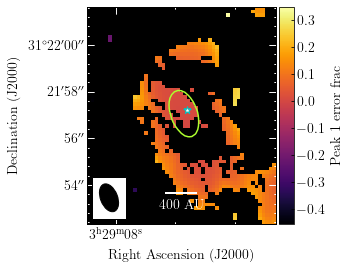

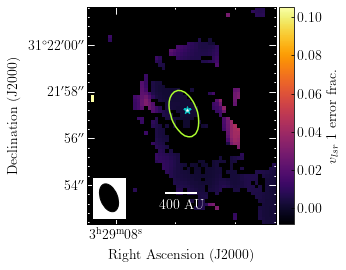

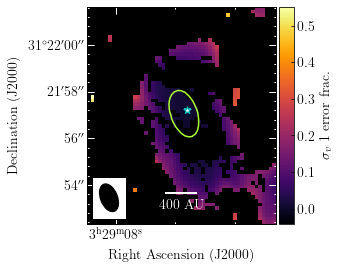

In [82]:
# Plot the error fraction to make sure everything is ok
saveaction = 1

filename = 'SO_55_44/CDconfigsmall/gaussian_fit_1_2_G/Per-emb-50_CD_l009l048_uvsub_SO_multi_small' + '_1G_fitparams_aicres'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

parameters = [0, 1, 2] # 0, 3 is amplitude, 1,4 is mean velocity, 2,5 is dispersion
parameter_names = [r'Peak 1 error frac', r'$v_{lsr}$ 1 error frac.', r'$\sigma_v$ 1 error frac.', r'Peak 2 error frac.', r'$v_{lsr}$ 2 error frac.', r'$\sigma_v$ 2 error frac.',]
for i in range(len(parameters)):
  moment = paramcube[i]
  momerror = paramcube[i+3]
  
  fig = plot_aplpy_standard(fits.PrimaryHDU(data=momerror/moment, header=header), stretch, None, None, 'inferno', label_col='w', star_col='c')
  fig.colorbar.set_axis_label_text(parameter_names[i])
  fig.scalebar.set_length(ang_size)
  fig.scalebar.set_label('400 AU')
  fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='greenyellow')
  fig.set_nan_color('k')
  if saveaction:
    savefile = filename + 'parametererror'+str(i)+'.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)
  

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap.

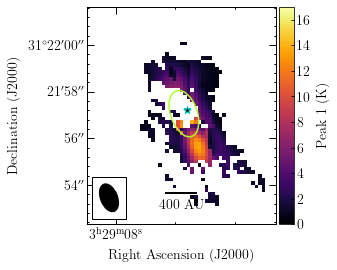

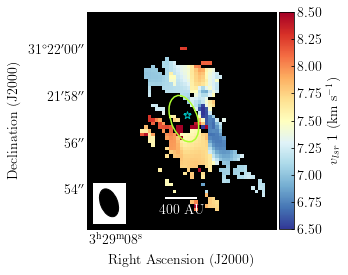

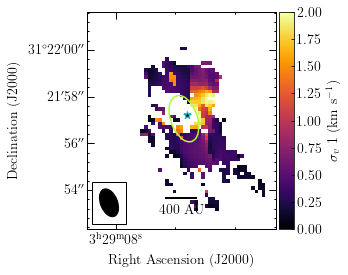

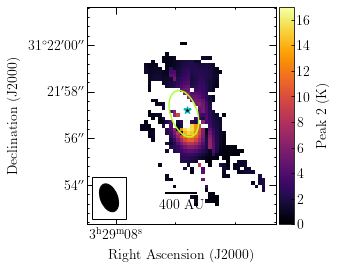

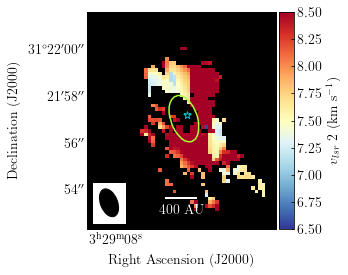

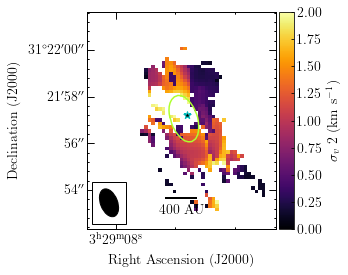

In [78]:
# Load the cube with pyspeckit
saveaction = 1

filename = 'SO_55_44/CDconfigsmall/gaussian_fit_1_2_G/Per-emb-50_CD_l009l048_uvsub_SO_multi_small' + '_2G_fitparams_aicres'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

parameters = [0, 1, 2, 3, 4, 5] # 0 is amplitude, 1 is mean velocity, 2 is dispersion
vmin = [0, 6.5, 0, 0, 6.5, 0]
vmax = [17, 8.5, 2, 17, 8.5, 2]
parameter_names = [r'Peak 1 (K)', r'$v_{lsr}$ 1 (km s$^{-1}$)', r'$\sigma_v$ 1 (km s$^{-1}$)', r'Peak 2 (K)', r'$v_{lsr}$ 2 (km s$^{-1}$)', r'$\sigma_v$ 2 (km s$^{-1}$)',]
cmaps = ['inferno', 'RdYlBu_r', 'inferno', 'inferno', 'RdYlBu_r', 'inferno']
nancolor = ['w', 'k', 'w', 'w', 'k', 'w']
ang_size = (400 / 293) * u.arcsec
for i in parameters:
  moment = paramcube[i]
  fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin[i], vmax[i], cmaps[i], label_col='k', star_col='c')
  fig.colorbar.set_axis_label_text(parameter_names[i])
  fig.scalebar.set_length(ang_size)
  fig.scalebar.set_label('400 AU')
  fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='greenyellow')
  if nancolor[i] == 'k':
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
    fig.scalebar.set_color('w')
  else:
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
  fig.set_nan_color(nancolor[i])
  if saveaction:
    savefile = filename + 'parameter'+str(i)+'.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)



INFO: Auto-setting vmin to -3.765e-02 [aplpy.core]
INFO: Auto-setting vmax to  5.443e-01 [aplpy.core]
INFO: Auto-setting vmin to -4.647e-03 [aplpy.core]
INFO: Auto-setting vmax to  6.529e-02 [aplpy.core]
INFO: Auto-setting vmin to -3.794e-02 [aplpy.core]
INFO: Auto-setting vmax to  5.236e-01 [aplpy.core]
INFO: Auto-setting vmin to -4.220e-02 [aplpy.core]
INFO: Auto-setting vmax to  5.475e-01 [aplpy.core]
INFO: Auto-setting vmin to -5.127e-03 [aplpy.core]
INFO: Auto-setting vmax to  7.700e-02 [aplpy.core]
INFO: Auto-setting vmin to -3.849e-02 [aplpy.core]
INFO: Auto-setting vmax to  5.297e-01 [aplpy.core]


/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap.

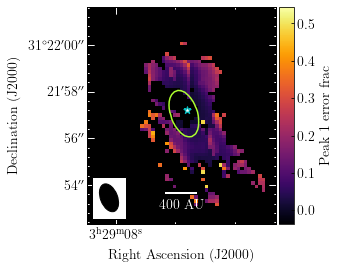

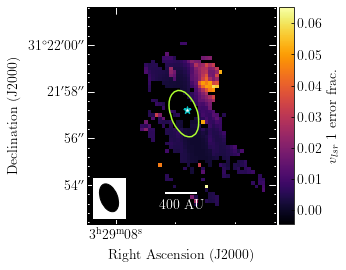

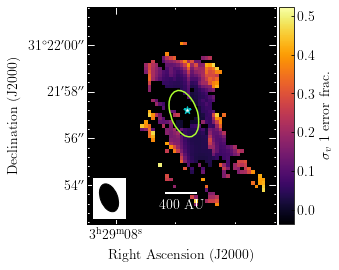

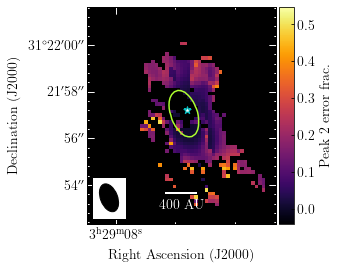

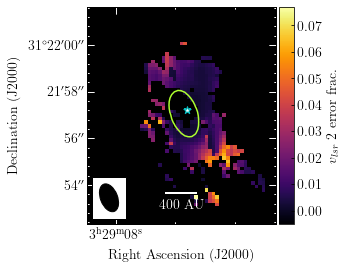

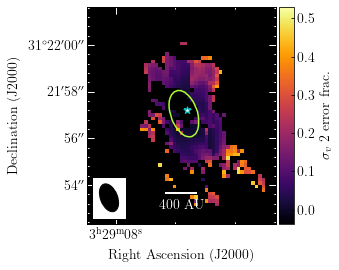

In [81]:
# Plot the error fraction to make sure everything is ok
saveaction = 1

filename = 'SO_55_44/CDconfigsmall/gaussian_fit_1_2_G/Per-emb-50_CD_l009l048_uvsub_SO_multi_small' + '_2G_fitparams_aicres'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

parameters = [0, 1, 2, 3, 4, 5] # 0, 3 is amplitude, 1,4 is mean velocity, 2,5 is dispersion
parameter_names = [r'Peak 1 error frac', r'$v_{lsr}$ 1 error frac.', r'$\sigma_v$ 1 error frac.', r'Peak 2 error frac.', r'$v_{lsr}$ 2 error frac.', r'$\sigma_v$ 2 error frac.',]
for i in range(len(parameters)):
  moment = paramcube[i]
  momerror = paramcube[i+6]
  
  fig = plot_aplpy_standard(fits.PrimaryHDU(data=momerror/moment, header=header), stretch, None, None, 'inferno', label_col='w', star_col='c')
  fig.colorbar.set_axis_label_text(parameter_names[i])
  fig.scalebar.set_length(ang_size)
  fig.scalebar.set_label('400 AU')
  fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='greenyellow')
  fig.set_nan_color('k')
  if saveaction:
    savefile = filename + 'parametererror'+str(i)+'.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)
  


### SO 3 gaussian fit

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


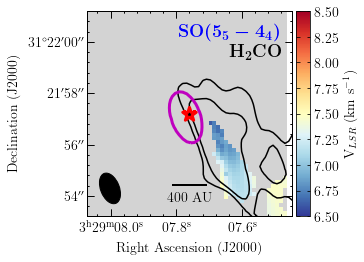

In [9]:
saveaction = 1

filename = 'SO_55_44/CDconfigsmall/Per-emb-50_CD_l009l048_uvsub_SO_multi_small_gaussian_streamer_model'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) * u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
moment = paramcube[1]
title_SO = r'\textbf{SO(5\boldmath$_{5}-4_4)$}'
title_H2CO = r'\textbf{H\boldmath$_{2}$CO}'
vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'

ang_size = (400 / 293) * u.arcsec

filename_contour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levels = np.array([3,5]) * 0.25 # K km/s

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.set_nan_color('lightgrey')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
fig.show_contour(filename_contour+'.fits', levels=levels, colors='k')
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='m', linewidths=3)
fig.recenter(ra_Per50.value, dec_Per50.value, (4*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([200])
fig._layers['star']._linewidths = np.array([3.])
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_frame(False)
fig.add_label(0.95,0.9, title_SO, color='b',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.95,0.8, title_H2CO, color='k',
               relative=True, horizontalalignment='right', size=18)
if saveaction:
    savefile = filename + '_v_lsr_H2CO_cont.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Plot SO with H2CO contours

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


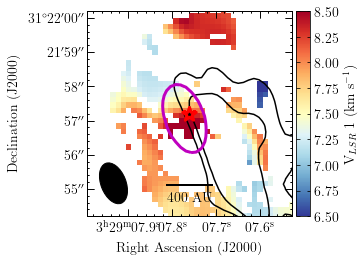

In [7]:
saveaction = 1

filename = 'SO_55_44/CDconfigsmall/Per-emb-50_CD_l009l048_uvsub_SO_multi_small' + '_1G_fitparams_aicres'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
moment = paramcube[1]

vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'


ang_size = (400 / 293) * u.arcsec

filename_contour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levels = np.array([3,5]) * 0.25 # K km/s

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ 1 (km s$^{-1}$)')
fig.show_contour(filename_contour+'.fits', levels=levels, colors='k')
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='m', linewidths=3)
fig.recenter(ra_Per50.value, dec_Per50.value, (3*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([200])
fig._layers['star']._linewidths = np.array([3.])
fig.tick_labels.set_xformat('hh:mm:ss.s')
fig.beam.set_frame(False)

if saveaction:
    savefile = filename + '_v_lsr1_H2CO_cont.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)
  

## H2CO Plots

### Moment 0

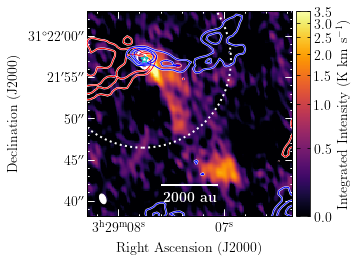

In [17]:
saveaction = 0

folder = 'H2CO/CDconfigsmall/'
filename = H2CO_303_202_TdV_s
cleanalg = 'Multi'
stretch = 'arcsinh'

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
levels = [0.007]

continuum_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()
continuum_data = fits.getdata(filename_continuum+'.fits')[0]
hdu_cont = fits.PrimaryHDU(data=continuum_data, header=continuum_header)

savefile = folder + 'H2CO_'+cleanalg+'_fitcube_total_mom0_labeled_continuum' + stretch + '_withoutflow.pdf'
vmin = 0
vmax = 3.5
vmid = 0.5
cmap = 'inferno'
title = r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$), NOEMA}'

contourblue = CO21blue
contourred = CO21red
levelblue = np.mgrid[0.58:2:0.5]
levelred = np.mgrid[0.58:2:1]

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='c', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
# fig.add_label(0.97,0.9, title, color='w',
#                relative=True, horizontalalignment='right', size=14)
# fig.add_label(0.95,0.80, cleanalg, color='k',
#                relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 au}')
fig.show_contour(hdu_cont, levels=levels, colors='w', linewidths=2)
fig.show_contour(contourblue+'.fits', levels=levelblue, colors='b', linewidths = 1, zorder=21)
fig.show_contour(contourred+'.fits', levels=levelred, colors='r', linewidths = 1, zorder = 20)
fig.show_contour(contourblue+'.fits', levels=levelblue, colors='w', linewidths = 2, zorder=11)
fig.show_contour(contourred+'.fits', levels=levelred, colors='w', linewidths = 2, zorder=10)
fig.beam.set_frame(False)
fig.beam.set_color('w')
if saveaction:
  
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


### Moment 1

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  cm.set_bad(color)


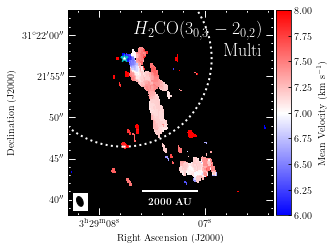

In [9]:
saveaction = 1
filename = H2CO_303_202_s + '_fitcube_total_mom1'
stretch = 'linear'
cmap = 'bwr'
nancolor = 'k'
savefile = folder + 'H2CO_'+cleanalg+'_fitcube_total_mom1' + '_'+stretch + '.pdf'
vmin = 6
vmax = 8

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='c')
fig.colorbar.set_axis_label_text(r'Mean Velocity (km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)

fig.add_label(0.95,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.95,0.80, cleanalg, color='w',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.set_nan_color(nancolor)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Moment 2 (sigma)

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)


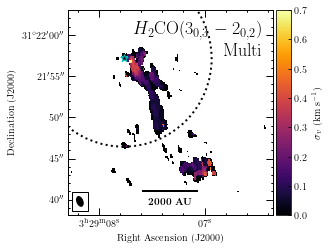

In [16]:
saveaction = 1
filename = H2CO_303_202_s + '_fitcube_total_sigma'
stretch = 'linear'
cmap = 'inferno'
nancolor = 'w'
savefile = folder + 'H2CO_'+cleanalg+'_fitcube_total_sigma' + '_'+stretch + '.pdf'
vmin = 0
vmax = 0.7

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c')
fig.colorbar.set_axis_label_text(r'$\sigma_v$ (km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)

fig.add_label(0.95,0.9, title, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.95,0.80, cleanalg, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.set_nan_color(nancolor)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Moment 8

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)


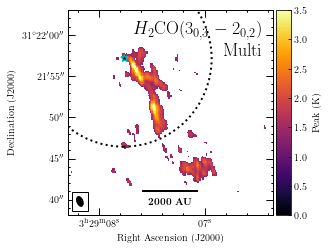

In [18]:
saveaction = 1
filename = H2CO_303_202_s + '_fitcube_total_mom8'
stretch = 'linear'
cmap = 'inferno'
nancolor = 'w'
savefile = folder + 'H2CO_'+cleanalg+'_fitcube_total_mom8' + '_'+stretch + '.pdf'
vmin = 0
vmax = 3.5

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c')
fig.colorbar.set_axis_label_text(r'Peak (K)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)

fig.add_label(0.95,0.9, title, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.add_label(0.95,0.80, cleanalg, color='k',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.set_nan_color(nancolor)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

## Noise plots


### H2CO

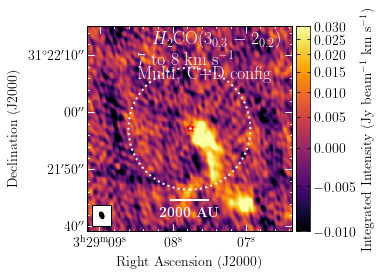

In [3]:
saveaction = 0
contourplot = 0
regionplot = 0

folder = 'H2CO/CDconfig/'
filename = H2CO_303_202
cleanalg = 'Multi, C+D config'
stretch = 'arcsinh'
moment = 0
velinit = 7 #km/s
velend = 8 #km/s
savefile = folder + 'H2CO_'+cleanalg+'_'+str(velinit)+'to'+str(velend)+'_'+stretch+'_moment'+str(moment)+'.pdf'
vmin = -0.01
vmax = 0.03
vmid = 0.001
cmap = 'inferno'
radiusplot = 18/3600
title = r'$H_{2}$CO($3_{0,3}-2_{0,2}$)\\'+str(velinit)+' to '+str(velend)+r' km s$^{-1}$\\'+cleanalg

contourfile = 'SO_55_44/Per-emb-50_C_l009l048_cont.fits'
contourfile2 = filename+'.fits'
contlevels = [0.007]
regions = folder +'spectra_regs.reg'

cube = SpectralCube.read(filename+'.fits')
cube = cube.with_spectral_unit(u.km/u.s)
headercube = cube.hdu.header
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

subcube = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
moment = subcube.moment(order=moment).hdu
rms = calculatenoise(moment.data)[0]
if contourplot:
    contourfile = SpectralCube.read(contourfile)
    contourfile = contourfile[0,:,:]
    contourfile2 = SpectralCube.read(contourfile2).with_spectral_unit(u.km/u.s)
    contour2 = contourfile2.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s).moment(order=moment).hdu
    rms2 = calculatenoise(contour2.data)[0]


fig = plot_aplpy_standard(moment, stretch, vmin, vmax, cmap, vmid=vmid)
fig.recenter(phasecent[0], phasecent[1], radiusplot)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (Jy beam$^{-1}$ km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
if contourplot:
    fig.show_contour(contour2, levels=[rms2*3, rms2*5], colors='w')
if regionplot:
    fig.show_regions(regions)
fig.add_label(0.95,0.85, title, color='white',
               relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


### Gaussian Fit result plots

#### H2CO fit results

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-

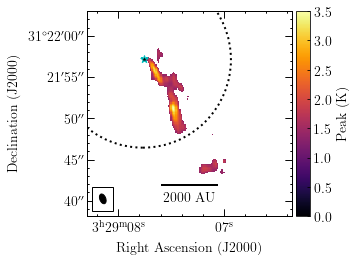

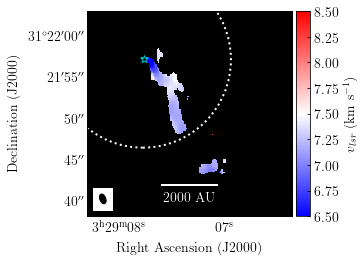

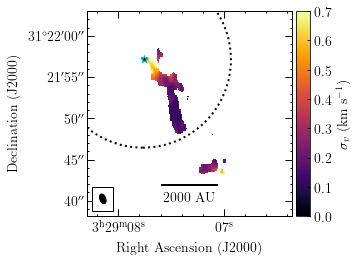

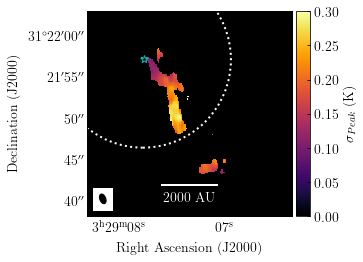

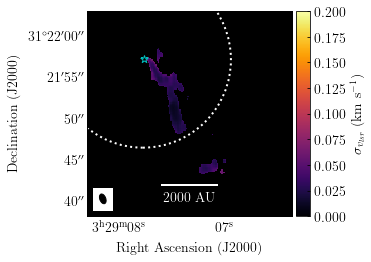

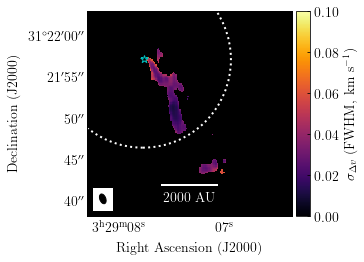

In [4]:
saveaction = 1

filename = H2CO_303_202_s + '_1G_fitparams'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

parameters = [0, 1, 2, 3, 4, 5] # 0 is amplitude, 1 is mean velocity, 2 is dispersion
vmin = [0, 6.5, 0, 0, 0, 0]
vmax = [3.5, 8.5, 0.7, 0.3, 0.2, 0.1]
parameter_names = [r'Peak (K)', r'$v_{lsr}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)', r'$\sigma_{Peak}$ (K)', r'$\sigma_{v_{lsr}}$ (km s$^{-1}$)', r'$\sigma_{\Delta v}$ (FWHM, km s$^{-1}$)']
cmaps = ['inferno', 'bwr', 'inferno', 'inferno', 'inferno', 'inferno']
nancolor = ['w', 'k', 'w', 'k', 'k', 'k']
for i in parameters:
  moment = paramcube[i]
  fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin[i], vmax[i], cmaps[i], label_col='k', star_col='c')
  fig.colorbar.set_axis_label_text(parameter_names[i])
  if nancolor[i] == 'k':
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
    fig.scalebar.set_color('w')
  else:
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
  fig.set_nan_color(nancolor[i])
  if saveaction:
    savefile = filename + 'parameter'+str(i)+'.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)




/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)


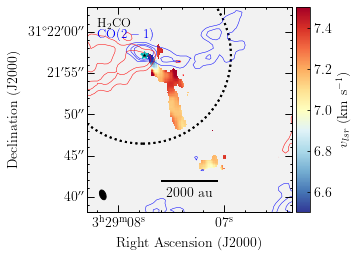

In [3]:
# Just the H2CO velocity component
saveaction = 1

filename = H2CO_303_202_s + '_1G_fitparams'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
velocity = paramcube[1]
vmin = 6.5
vmax = 7.5
cmap = 'RdYlBu_r'
nancolor = np.array([1,1,1])*0.95

contourblue = CO21blue
contourred = CO21red
levelblue = np.mgrid[0.58:2:0.5]
levelred = np.mgrid[0.58:2:1]


savefile = filename + '_v_lsr_6.5_7.5_withoutflow.pdf'

fig = plot_aplpy_standard(fits.PrimaryHDU(data=velocity, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='c')
fig.colorbar.set_axis_label_text(r'$v_{lsr}$ (km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
fig.set_nan_color(nancolor)
fig.beam.set_frame(False)
fig.show_contour(contourblue+'.fits', levels=levelblue, colors='b', linewidths = 0.5)
fig.show_contour(contourred+'.fits', levels=levelred, colors='r', linewidths = 0.5)
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
fig.add_label(0.05,0.92, r'H$_{2}$CO', color='k',
               relative=True, horizontalalignment='left', size=13)
fig.add_label(0.05,0.86, r'CO($2-1$)', color='b',
               relative=True, horizontalalignment='left', size=13)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


For comparison, we plot the moment map (plotted before)

### H2CO zoom into gradient with H2CO contours

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


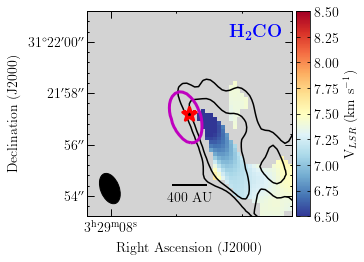

In [10]:
saveaction = 1

filename = H2CO_303_202_s + '_1G_fitparams'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']
moment = paramcube[1]
vmin = 6.5
vmax = 8.5
cmap = 'RdYlBu_r'

ang_size = (400 / 293) * u.arcsec
title = r'\textbf{H\boldmath$_{2}$CO}'
filename_contour = 'H2CO/CDconfigsmall/Per-emb-50_CD_l021l060_uvsub_H2CO_multi_small_fitcube_stream_mom0'
levels = np.array([3,5]) * 0.25 # K km/s

filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()

fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin, vmax, cmap, label_col='k', star_col='r')
fig.set_nan_color('lightgrey')
fig.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
fig.show_contour(filename_contour+'.fits', levels=levels, colors='k')
fig.scalebar.set_length(ang_size)
fig.scalebar.set_label('400 AU')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='m', linewidths=3)
fig.recenter(ra_Per50.value, dec_Per50.value, (4*u.arcsec).to(u.deg).value)
fig._layers['star']._sizes = np.array([200])
fig._layers['star']._linewidths = np.array([3.])
fig.beam.set_frame(False)
fig.add_label(0.95,0.9, title, color='b',
               relative=True, horizontalalignment='right', size=18)
if saveaction:
    savefile = filename + '_v_lsr_H2CO_cont.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)
  


### Outflow plot for comparison

#### H2CO with CO(2-1) contours

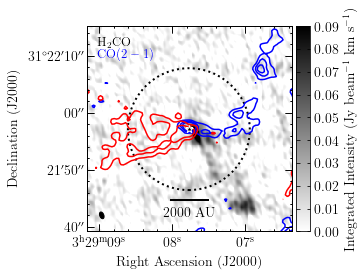

In [13]:
saveaction = 1
folder = 'H2CO/CDconfig/'
filename = H2CO_303_202_TdV
stretch = 'linear'
header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]
savefile = folder + 'H2CO_moment0_CO21.pdf'

contourblue = CO21blue
contourred = CO21red
levelblue = np.mgrid[0.58:2:0.5]
levelred = np.mgrid[0.58:2:1]
cmap = 'gray_r'

vmin = 0
vmax = 0.09

fig = plot_aplpy_standard(filename + '.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='w')
fig.recenter(ra_Per50.value, dec_Per50.value, (18*u.arcsec).to(u.deg).value)
fig.show_contour(contourblue+'.fits', levels=levelblue, colors='b')
fig.show_contour(contourred+'.fits', levels=levelred, colors='r')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
fig.add_label(0.05,0.92, r'H$_{2}$CO', color='k',
               relative=True, horizontalalignment='left', size=13)
fig.add_label(0.05,0.86, r'CO($2-1$)', color='b',
               relative=True, horizontalalignment='left', size=13)
# fig.add_label(0.05,0.8, r'CO($2-1$)', color='r',
#                relative=True, horizontalalignment='left', size=13)
fig.colorbar.set_axis_label_text('Integrated Intensity (Jy beam$^{-1}$ km s$^{-1}$)')
fig.beam.set_frame(False)
if saveaction:
  plt.savefig(savefile, bbox_inches='tight', dpi=300)



### Streamline model plots

In [6]:
# Load the streamline results
modelname = 'H2CO_0.18Msun_env_2'
pickle_in = open('analysis/streamer_model_'+modelname+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra = streamdict['ra']
dec = streamdict['dec']
dsky = streamdict['d_sky_au']
vel = streamdict['vlsr']
pickle_in = open('analysis/streamer_model_'+modelname+'_params.pickle', "rb")
paramsdict = pickle.load(pickle_in)
omega0 = paramsdict['omega0']
r0 = paramsdict['r0']
v_lsr = paramsdict['v_lsr']

regionfile = 'data/region_streamer_l.reg'

# Load source params
M_s = 1.71*u.Msun # was 2.9
M_env = 0.18*u.Msun # was 2.2
# M_env = 2.2*u.Msun
M_disk = 0.58*u.Msun
Mstar = (M_s+M_env+M_disk)
r_c = SL.r_cent(Mstar, omega0, r0)
print(paramsdict)


{'theta0': <Quantity 61.5 deg>, 'r0': <Quantity 3330. AU>, 'phi0': <Quantity 28. deg>, 'v_r0': <Quantity 1.25 km / s>, 'omega0': <Quantity 4.53e-13 1 / s>, 'v_lsr': <Quantity 7.48 km / s>}


In [12]:
modelname = 'H2CO_0.18Msun_env_2'
pickle_in = open('analysis/streamer_model_'+modelname+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
dsky = streamdict['d_sky_au']
vel1 = streamdict['vlsr']

modelname = 'H2CO_0.39Msun_env'
pickle_in = open('analysis/streamer_model_'+modelname+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
vel2 = streamdict['vlsr']

diff = vel1-vel2[:321]
print(np.amax(diff))

0.07614067372285493 km / s


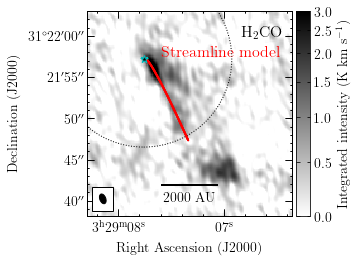

In [5]:
saveplot = 0

# Plot the image plane
filename = H2CO_303_202_
stretch = 'arcsinh'
header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]
vmin = 0
vmax = 3
vmid = 1
cmap='gray_r'
fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c', vmid=vmid)
fig.show_circles(ra_Per50, dec_Per50, pb_noema(freq).to(u.deg)*0.5,
                  ls=':', color='black')
fig.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
fig.show_markers(ra, dec, marker='o', color='red', s=1)
fig.add_label(0.85, 0.9, r'H$_2$CO', relative=True, size=16, weight='bold')
fig.add_label(0.65, 0.8, r'Streamline model', relative=True, size=16, color='r', weight='bold')
if saveplot:
  fig.savefig('analysis/streamline_image_peremb50_'+modelname+'.pdf', dpi=300)

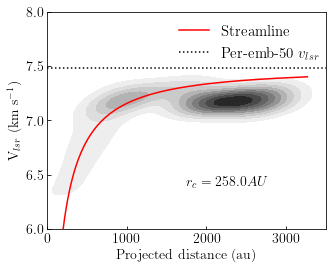

In [5]:
# Plot the velocity plane
saveplot = 1
r_proj, v_los = per_emb_50_get_vc_r(H2CO_303_202_pb_fit_Vc+'.fits', regionfile)

# create the grid for the kernel distribution
xmin = 0
xmax = 3500
ymin = 6.
ymax = 8.
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#
gd_vlos = np.isfinite(r_proj*v_los)  # filter nan
values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])

kernel = stats.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)
zz /= zz.max()  # normalization of probability

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
ax.set_xlabel('Projected distance (au)')
ax.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.set_ylim([6,8])
ax.set_xlim([0, 3500])


ax.plot(dsky, vel, color='red', label='Streamline')
ax.axhline(v_lsr.value, color='k', label=r'Per-emb-50 $v_{lsr}$', ls=':')
ax.annotate(r'$r_c = {}$'.format(np.round(r_c,0)), (0.5, 0.2), xycoords='axes fraction', size=14)
ax.legend(loc=(0.45, 0.75), frameon=False, fontsize=15)
if saveplot:
  fig.savefig('analysis/streamline_pbcor_vlsr_r_kde_peremb50_'+modelname+'.pdf', dpi=300, bbox_inches='tight')

#### Comparison between the two envelope masses with the same parameters

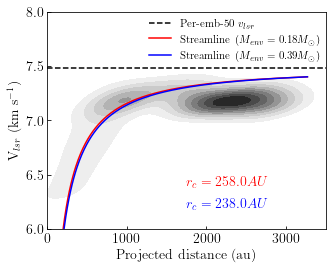

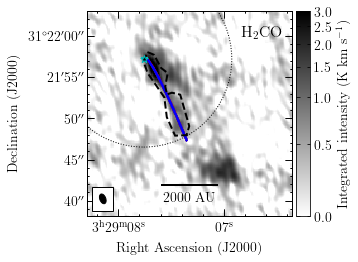

In [15]:
saveplot = 1
regionfile = 'data/region_streamer_l.reg'
r_proj, v_los = per_emb_50_get_vc_r(H2CO_303_202_fit_Vc+'.fits', regionfile)

# create the grid for the kernel distribution
xmin = 0
xmax = 3500
ymin = 6.
ymax = 8.
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#
gd_vlos = np.isfinite(r_proj*v_los)  # filter nan
values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])

kernel = stats.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)
zz /= zz.max()  # normalization of probability

# plot for kde
fig2 = plt.figure(figsize=(5, 4))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.set_ylim([6,8])
ax2.set_xlim([0, 3500])

#Plot for image
filename = H2CO_303_202_TdV_s
stretch = 'arcsinh'
header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]
vmin = 0
vmax = 3
vmid = 0.5
cmap='gray_r'

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c', vmid=vmid)
fig.show_circles(ra_Per50, dec_Per50, pb_noema(freq).to(u.deg)*0.5,
                  ls=':', color='black')
fig.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
fig.add_label(0.85, 0.9, r'H$_2$CO', relative=True, size=16, weight='bold')
fig.show_regions(regionfile)

# Load the streamline results
modelname1 = 'H2CO_0.18Msun_env_2'
modelname2 = 'H2CO_0.39Msun_env'
pickle_in = open('analysis/streamer_model_'+modelname1+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra1 = streamdict['ra']
dec1 = streamdict['dec']
dsky1 = streamdict['d_sky_au']
vel1 = streamdict['vlsr']
pickle_in = open('analysis/streamer_model_'+modelname1+'_params.pickle', "rb")
paramsdict = pickle.load(pickle_in)
omega01 = paramsdict['omega0']
r01 = paramsdict['r0']
pickle_in = open('analysis/streamer_model_'+modelname2+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra2 = streamdict['ra']
dec2 = streamdict['dec']
dsky2 = streamdict['d_sky_au']
vel2 = streamdict['vlsr']
pickle_in = open('analysis/streamer_model_'+modelname2+'_params.pickle', "rb")
paramsdict = pickle.load(pickle_in)
omega02 = paramsdict['omega0']
r02 = paramsdict['r0']

v_lsr = paramsdict['v_lsr']

# Load source params
M_s = 1.71*u.Msun # was 2.9
M_env1 = 0.18*u.Msun
M_env2 = 0.39*u.Msun
M_disk = 0.58*u.Msun
Mstar1 = (M_s+M_env1+M_disk)
Mstar2 = (M_s+M_env2+M_disk)
r_c1 = SL.r_cent(Mstar1, omega01, r01)
r_c2 = SL.r_cent(Mstar2, omega02, r02)

# Add the models and labels in the kde

ax2.axhline(v_lsr.value, color='k', label=r'Per-emb-50 $v_{lsr}$', ls='--')
ax2.plot(dsky1, vel1, color='red', label=r'Streamline ($M_{env}=0.18M_{\odot}$)')
ax2.annotate(r'$r_c = {}$'.format(np.round(r_c1,0)), (0.5, 0.2), xycoords='axes fraction', size=14, color='r')
ax2.plot(dsky2, vel2, color='blue', label=r'Streamline ($M_{env}=0.39M_{\odot}$)')
ax2.annotate(r'$r_c = {}$'.format(np.round(r_c2,0)), (0.5, 0.1), xycoords='axes fraction', size=14, color='b')
ax2.legend(loc=(0.35, 0.75), frameon=False, fontsize=11)

#add the models and labels in the image
fig.show_markers(ra1, dec1, marker='o', c='red', s=0.5)
# fig.add_label(0.3, 0.3, r'$M_{env}=0.18M_{\odot}$', relative=True, size=16, color='r', weight='bold')
fig.show_markers(ra2, dec2, marker='o', c='b', s=0.5)
# fig.add_label(0.3, 0.2, r'$M_{env}=0.39M_{\odot}$', relative=True, size=16, color='b', weight='bold')

if saveplot:
  fig2.savefig('analysis/streamline_comparison_Menv_vlsr_r_kde_peremb50.pdf', dpi=300, bbox_inches='tight')
  fig.savefig('analysis/streamline_image_comparison_Menv_peremb50.pdf', dpi=300)



## C18O plots

### Moment 0 map

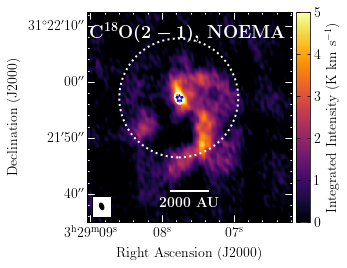

In [15]:
saveaction = 1

folder = 'C18O/CDconfig/'
filename = C18O_2_1_TdV 
cleanalg = 'Multi'
stretch = 'linear'

savefile = folder + 'C18O_'+cleanalg+'_fitcube_total_mom0_labeled_continuum_' + stretch + '.pdf'
vmin = 0
vmax = 5
vmid = 0.5
cmap = 'inferno'
title = r'\textbf{C\boldmath$^{18}$O($2-1$), NOEMA}'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.97,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
# fig.add_label(0.95,0.80, cleanalg, color='k',
#                relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.show_contour(hdu_cont, levels=levels, colors='w', linewidths=2)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### C18O with H2CO overlaid

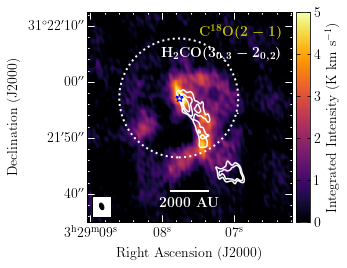

In [18]:
saveaction = 1

folder = 'C18O/CDconfig/'
filename = C18O_2_1_TdV 
filename_contour = H2CO_303_202_TdV_s
cleanalg = 'Multi'
stretch = 'linear'

savefile = folder + 'C18O_'+cleanalg+'_fitcube_total_mom0' + '_'+stretch + '_H2COcontour.pdf'
vmin = 0
vmax = 5
vmid = 0.5
cmap = 'inferno'
title = r'\textbf{C\boldmath$^{18}$O($2-1$)}'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.95,0.9, title, color='y',
               relative=True, horizontalalignment='right', size=14)
fig.scalebar.set_label(r'\textbf{2000 AU}')

rms, __ = calculatenoise(fits.getdata(filename_contour+'.fits'))
levels = rms * np.array([3, 5, 10])
fig.show_contour(filename_contour+'.fits', colors='w', levels=levels)
fig.add_label(0.95,0.8, r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$)}', color='w',
               relative=True, horizontalalignment='right', size=14)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


### Fit results

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  cm.set_bad(color)
/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-

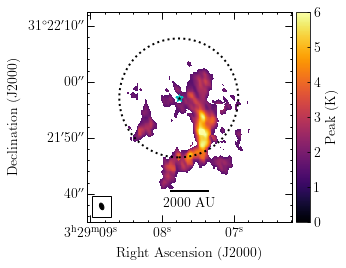

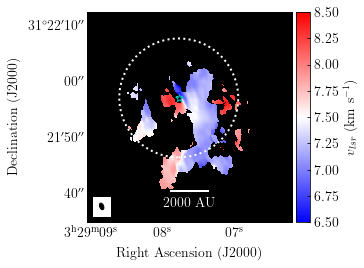

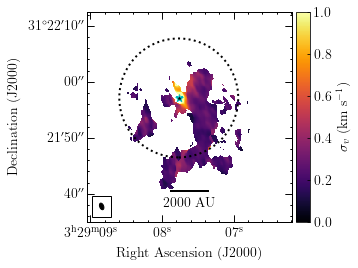

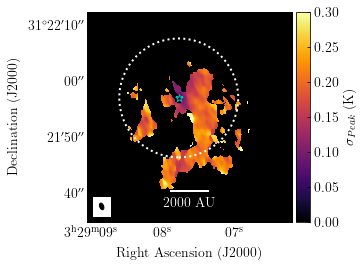

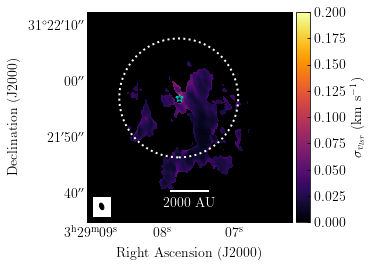

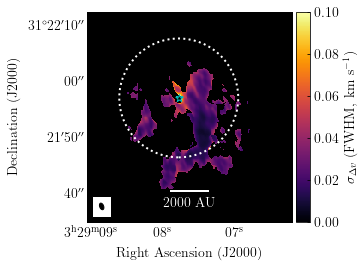

In [7]:
saveaction = 0

filename = C18O_2_1_s + '_1G_fitparams'
stretch = 'linear'
paramcube = fits.getdata(filename+'.fits')
head = fits.getheader(filename+'.fits')
phasecent = np.array([head['ra'], head['dec']]) *u.deg
freq = head['restfreq'] * u.Hz
header = WCS(head).celestial.to_header()
header['bmaj'] = head['bmaj']
header['bmin'] = head['bmin']
header['bpa'] = head['bpa']

parameters = [0, 1, 2, 3, 4, 5] # 0 is amplitude, 1 is mean velocity, 2 is dispersion
vmin = [0, 6.5, 0, 0, 0, 0]
vmax = [6, 8.5, 1.0, 0.3, 0.2, 0.1]
parameter_names = [r'Peak (K)', r'$v_{lsr}$ (km s$^{-1}$)', r'$\sigma_v$ (km s$^{-1}$)', r'$\sigma_{Peak}$ (K)', r'$\sigma_{v_{lsr}}$ (km s$^{-1}$)', r'$\sigma_{\Delta v}$ (FWHM, km s$^{-1}$)']
cmaps = ['inferno', 'bwr', 'inferno', 'inferno', 'inferno', 'inferno']
nancolor = ['w', 'k', 'w', 'k', 'k', 'k']
for i in parameters:
  moment = paramcube[i]
  fig = plot_aplpy_standard(fits.PrimaryHDU(data=moment, header=header), stretch, vmin[i], vmax[i], cmaps[i], label_col='k', star_col='c')
  fig.colorbar.set_axis_label_text(parameter_names[i])
  if nancolor[i] == 'k':
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
    fig.scalebar.set_color('w')
  else:
    fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
  fig.set_nan_color(nancolor[i])
  if saveaction:
    savefile = filename + 'parameter'+str(i)+'.pdf'
    plt.savefig(savefile, bbox_inches='tight', dpi=300)


### Streamline model results

In [16]:
# Load the streamline results
modelname = 'C18O_0.18Msun_env'
pickle_in = open('analysis/streamer_model_'+modelname+'_vr.pickle', "rb")
streamdict = pickle.load(pickle_in)
ra = streamdict['ra']
dec = streamdict['dec']
dsky = streamdict['d_sky_au']
vel = streamdict['vlsr']
pickle_in = open('analysis/streamer_model_'+modelname+'_params.pickle', "rb")
paramsdict = pickle.load(pickle_in)
omega0 = paramsdict['omega0']
r0 = paramsdict['r0']
v_lsr = paramsdict['v_lsr']

regionfile = 'data/region_streamer_C18O_test4.reg'

# Load source params
M_s = 1.71*u.Msun # was 2.9
M_env = 0.18*u.Msun # was 2.2
M_disk = 0.58*u.Msun
Mstar = (M_s+M_env+M_disk)
r_c = SL.r_cent(Mstar, omega0, r0)
print(paramsdict)
print(2.47/500*1683)

{'theta0': <Quantity 89. deg>, 'r0': <Quantity 3670. AU>, 'phi0': <Quantity 163.5 deg>, 'v_r0': <Quantity 0. km / s>, 'omega0': <Quantity 9.53e-13 1 / s>, 'v_lsr': <Quantity 7.48 km / s>, 'inc': <Quantity -23. deg>, 'PA': <Quantity 110. deg>}
8.314020000000001


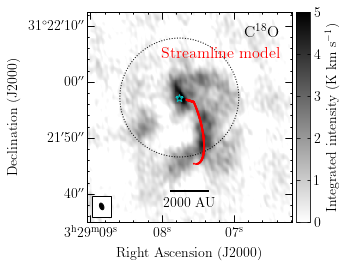

In [52]:
saveplot = 1

# Plot the image plane
filename = C18O_2_1_TdV
stretch = 'linear'
header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]
vmin = 0
vmax = 5
vmid = 1
cmap='gray_r'
fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='c', vmid=vmid)
fig.show_circles(ra_Per50, dec_Per50, pb_noema(freq).to(u.deg)*0.5,
                  ls=':', color='black')
fig.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
fig.show_markers(ra, dec, marker='o', color='red', s=1)
fig.add_label(0.85, 0.9, r'C$^{18}$O', relative=True, size=16, weight='bold')
fig.add_label(0.65, 0.8, r'Streamline model', relative=True, size=16, color='r', weight='bold')
if saveplot:
  fig.savefig('analysis/streamline_image_peremb50_'+modelname+'.pdf', dpi=300)

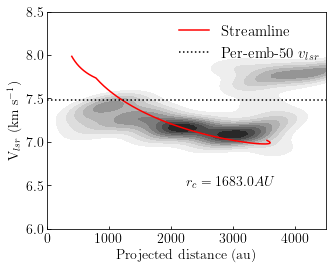

In [50]:
# Plot the velocity plane
saveplot = 1
r_proj, v_los = per_emb_50_get_vc_r(C18O_2_1_fit_Vc+'.fits', regionfile)

# create the grid for the kernel distribution
xmin = 0
xmax = 4500
ymin = 6.
ymax = 8.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#
gd_vlos = np.isfinite(r_proj*v_los)  # filter nan
values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])

kernel = stats.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)
zz /= zz.max()  # normalization of probability

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
ax.set_xlabel('Projected distance (au)')
ax.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.set_ylim([ymin, ymax])
ax.set_xlim([xmin, xmax])


ax.plot(dsky, vel, color='red', label='Streamline')
ax.axhline(v_lsr.value, color='k', label=r'Per-emb-50 $v_{lsr}$', ls=':')
ax.annotate(r'$r_c = {}$'.format(np.round(r_c,0)), (0.5, 0.2), xycoords='axes fraction', size=14)
ax.legend(loc=(0.45, 0.75), frameon=False, fontsize=15)
if saveplot:
  fig.savefig('analysis/streamline_pbcor_vlsr_r_kde_peremb50_'+modelname+'.pdf', dpi=300, bbox_inches='tight')

### C18O central velocity but with the outflows over it

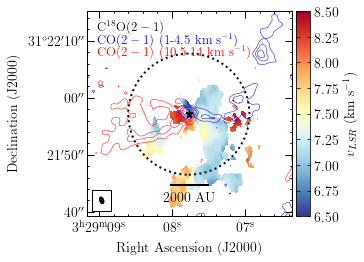

In [4]:
saveaction = 0

filename = C18O_2_1_fit_Vc
stretch = 'linear'

header = fits.getheader(filename+'.fits')
freq = header['RESTFREQ'] * u.Hz
phasecent = [header['ra'], header['dec']]

folder = 'C18O/CDconfig/JEP/'
savefile = folder + 'C18O_fit_Vc_CO21.pdf'

contourblue = CO21blue
contourred = CO21red
levelblue = np.mgrid[0.58:2:0.5]
levelred = np.mgrid[0.58:2:1]
cmap = 'RdYlBu_r'

vmin = 6.5
vmax = 8.5

fig = plot_aplpy_standard(filename + '.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='k')
fig.recenter(ra_Per50.value, dec_Per50.value, (18*u.arcsec).to(u.deg).value)
fig.show_contour(contourblue+'.fits', levels=levelblue, colors='b', linewidths=0.5)
fig.show_contour(contourred+'.fits', levels=levelred, colors='r', linewidths=0.5)
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='k', lw=2)
fig.add_label(0.05,0.92, r'C$^{18}$O($2-1$)', color='k',
               relative=True, horizontalalignment='left', size=13)
fig.add_label(0.05,0.86, r'CO($2-1$) (1-4.5 km s$^{-1}$)', color='b',
               relative=True, horizontalalignment='left', size=13)
fig.add_label(0.05,0.8, r'CO($2-1$) (10.5-14 km s$^{-1}$)', color='r',
               relative=True, horizontalalignment='left', size=13)
fig.colorbar.set_axis_label_text('$v_{LSR}$ (km s$^{-1}$)')

if saveaction:
  plt.savefig(savefile, bbox_inches='tight', dpi=300)

### N(C18O)

/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cm.set_bad(color)


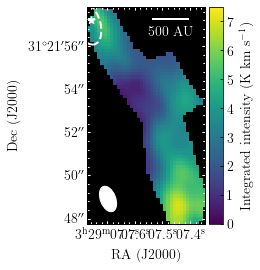

In [18]:
saveaction = 1
# folder = 'analysis/column_dens_maps/'
# filename = folder+'N_C18O_constantTex_10.0K_mom0_pbcor_kink'
folder = 'C18O/CDconfig/JEP/'
filename = folder+'JEP_mask_multi_Per-emb-50_CD_l025l064_uvsub_C18O_pbcor_reprojectH2COs_mom0_l_kink'
stretch = 'linear'
cmap = 'viridis'
# header = fits.getheader(filename+'.fits')
# freq = header['RESTFREQ'] * u.Hz
# phasecent = [header['ra'], header['dec']]
vmin = 0
vmax = 7.5
label_col='w'
star_col='w'
savefile = filename + '_with_cont.pdf'

distance = 293.
ang_size = (500 / distance) * u.arcsec
filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()


filename_continuum = 'continuum/Per-emb-50_CD_li_cont_rob1-selfcal'
cont_data = fits.getdata(filename_continuum+'.fits')[0]
cont_header = WCS(fits.getheader(filename_continuum+'.fits')).celestial.to_header()
# fig = plot_aplpy_standard(filename + '.fits', stretch, vmin, vmax, cmap, label_col='k', star_col='k')
fig = aplpy.FITSFigure(filename+'.fits', figsize=(4,4))
fig.show_colorscale(vmin=vmin,vmax=vmax)
fig.add_colorbar()
# fig.colorbar.set_axis_label_text(r'$N(\mathrm{C}^{18}\mathrm{O})$ (cm$^{-2}$)')
fig.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
fig.show_contour(fits.PrimaryHDU(data=cont_data,header=cont_header), levels=[0.007], colors='w', linewidths=2,linestyles='dashed')
fig.add_beam()
fig.set_system_latex(True)
fig.ticks.set_color(label_col)
fig.beam.set_color('w')
# fig.beam.set_frame(True)
fig.add_scalebar(ang_size, label='2000 AU', color=label_col, corner='top right')
fig.set_nan_color('k')
fig.scalebar.set_label('500 AU')
fig.scalebar.set_font(family='monospace', weight=1000)
fig.show_markers(ra_Per50.value, dec_Per50.value, marker='*', s=60, layer='star',
                       edgecolor=star_col, facecolor=label_col, zorder=31)
fig.scalebar.set_linewidth(2)
if saveaction:
  plt.savefig(savefile, bbox_inches='tight', dpi=300)


In [65]:
fig.ax.xaxis.label_position

'top'

## SO2 plots

#### Moment 0

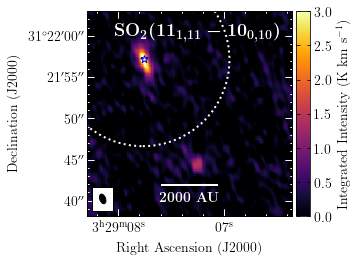

In [9]:
saveaction = 1

folder = 'SO2_11_1_11_10_0_10/CDconfig/'
filename = folder+'Per-emb-50_CD_l031l070_uvsub_SO2_multi_fitcube_stream_mom0'
cleanalg = 'Multi'
stretch = 'linear'

savefile = folder + 'C18O_'+cleanalg+'_fitcube_total_mom0' + '_'+stretch + '.pdf'
vmin = 0
vmax = 3
vmid = 0.5
cmap = 'inferno'
title = r'\textbf{SO\boldmath$_{2}$($11_{1,11}-10_{0,10}$)}'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]

fig = plot_aplpy_standard(filename+'.fits', stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Integrated Intensity (K km s$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.95,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
# fig.add_label(0.95,0.80, cleanalg, color='k',
#                relative=True, horizontalalignment='right', size=18)
fig.scalebar.set_label(r'\textbf{2000 AU}')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

# Continuum Image (preliminary)

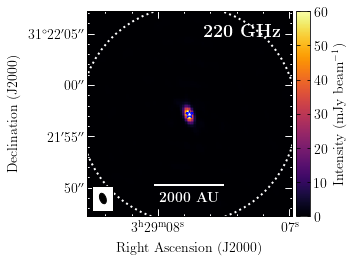

In [3]:
saveaction = 0

folder = 'continuum/'
filename = folder+'Per-emb-50_CD_li_cont_rob1-selfcal'
cleanalg = 'Multi'
stretch = 'linear'

savefile = filename + '_'+stretch + '.pdf'
vmin = 0
vmax = 60
vmid = 0.5
cmap = 'inferno'
title = r'\textbf{220 GHz}'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFREQ'] * u.Hz
phasecent = [headercube['ra'], headercube['dec']]
wcscel = WCS(headercube).celestial
new_header = wcscel.to_header()
new_header['bmaj'] = headercube['bmaj']
new_header['bmin'] = headercube['bmin']
new_header['bpa'] = headercube['bpa']
new_hdu = fits.PrimaryHDU(data=fits.getdata(filename+'.fits')[0]*1000,header=new_header)
fig = plot_aplpy_standard(new_hdu, stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Intensity (mJy beam$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.95,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=18)
# fig.add_label(0.95,0.80, cleanalg, color='k',
#                relative=True, horizontalalignment='right', size=18)
fig.recenter(ra_Per50.value, dec_Per50.value, (10*u.arcsec).to(u.deg).value)
fig.scalebar.set_label(r'\textbf{2000 AU}')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

# ALMA data (from D. Segura-Cox)

In [28]:
filename = 'ALMA/Per50_H2COa_natural_noSC_clean'
moment = 0 
int_range = 'total'
velinit = 5.5
velend = 9.5 # km/s

cube = SpectralCube.read(filename+'.fits').with_spectral_unit(u.km/u.s, velocity_convention='radio')
slab = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
moment0 = slab.moment(order=moment)
moment0.write(filename+'_mom0_'+int_range+'.fits')


/Users/mvaldivi/anaconda3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cm.set_bad(color)


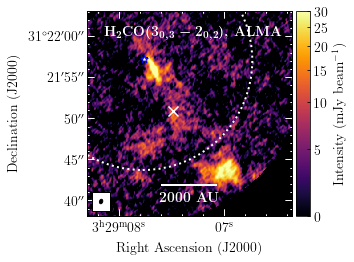

In [97]:
saveaction = 1
folder = 'ALMA/'
filename = folder+'Per50_H2COa_natural_noSC_clean_mom0_total'


savefile = filename + '_'+stretch + '.pdf'
vmin = 0
vmax = 30
vmid = 6
cmap = 'inferno'
title = r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$), ALMA}'
stretch='arcsinh'

headercube = fits.getheader(filename+'.fits')
freq = headercube['RESTFRQ'] * u.Hz
phasecent = [headercube['obsra'], headercube['obsdec']]
wcscel = WCS(headercube).celestial
new_header = wcscel.to_header()
new_header['bmaj'] = headercube['bmaj']
new_header['bmin'] = headercube['bmin']
new_header['bpa'] = headercube['bpa']
new_hdu = fits.PrimaryHDU(data=fits.getdata(filename+'.fits')*1000,header=new_header)
fig = plot_aplpy_standard(new_hdu, stretch, vmin, vmax, cmap, label_col='w', star_col='b', vmid=vmid)
fig.colorbar.set_axis_label_text(r'Intensity (mJy beam$^{-1}$)')
fig.show_circles(phasecent[0], phasecent[1], ((26.7*u.arcsec).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
fig.add_label(0.95,0.9, title, color='w',
               relative=True, horizontalalignment='right', size=14)
# fig.add_label(0.95,0.80, cleanalg, color='k',
#                relative=True, horizontalalignment='right', size=18)
fig.recenter(52.2805271, 31.3640439, (12.5*u.arcsec).to(u.deg).value)
fig.scalebar.set_label(r'\textbf{2000 AU}')
fig.set_nan_color('k')
plotpoint = [52.2811874,31.3641355]
fig.show_markers(plotpoint[0],plotpoint[1], c='w', s=100, marker='x')

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

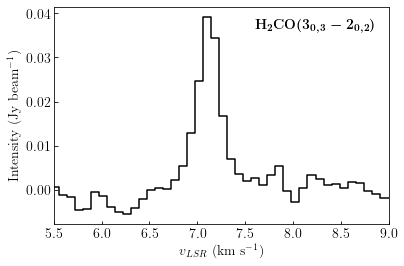

In [96]:
saveaction = 1
folder = 'ALMA/'
filename = folder+'Per50_H2COa_natural_noSC_clean'
cube = SpectralCube.read(filename+'.fits').with_spectral_unit(u.km/u.s, velocity_convention='radio')
wcscel = cube.wcs.celestial
x, y = wcscel.all_world2pix([52.2811874],[31.3641355],0)
spectra = cube[:,int(y[0]),int(x[0])]
vel = cube.spectral_axis.value

savefile = filename+'_sample_spectra.pdf'

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(vel,spectra,drawstyle='steps-mid', color='k')
ax.set_xlabel(r'$v_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'Intensity (Jy beam$^{-1}$)')
ax.set_xlim([5.5,9])
ax.annotate(r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$)}',(0.6,0.9), xycoords='axes fraction', color='k', size=14)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)